In [4]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [76]:
# 读入图像
img = cv2.imread('test3_3.jpg')
gray = cv2.imread('test3_3.jpg', 0)

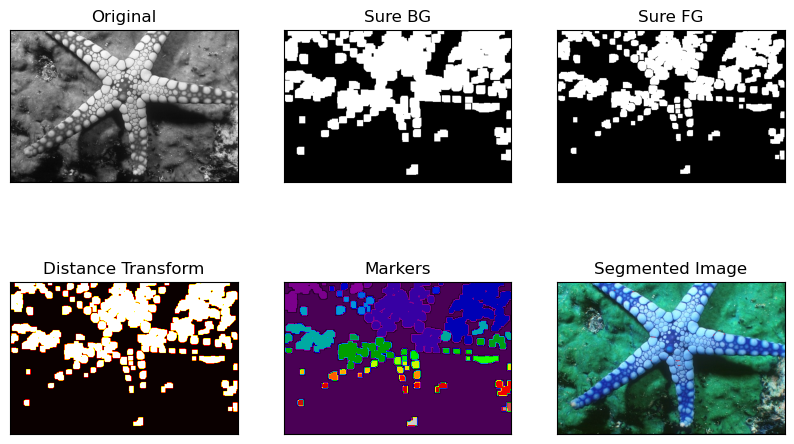

In [77]:
def otsu_threshold(image):

    # 计算图像的直方图和总像素数
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 256))
    total_pixels = image.size

    # 初始化类间方差、最佳阈值和累计变量
    current_max_variance = 0
    optimal_threshold = 0
    sum_total = np.dot(range(256), histogram)  # 所有像素的灰度值总和
    weight_background, sum_background = 0, 0

    # 遍历每个可能的阈值
    for threshold in range(256):
        # 计算背景和前景的权重
        weight_background += histogram[threshold]
        if weight_background == 0:
            continue
        weight_foreground = total_pixels - weight_background
        if weight_foreground == 0:
            break

        # 更新背景的灰度值累加和
        sum_background += threshold * histogram[threshold]

        # 计算背景和前景的均值
        mean_background = sum_background / weight_background
        mean_foreground = (sum_total - sum_background) / weight_foreground

        # 计算类间方差
        inter_class_variance = weight_background * weight_foreground * (mean_background - mean_foreground) ** 2

        # 更新最佳阈值
        if inter_class_variance > current_max_variance:
            current_max_variance = inter_class_variance
            optimal_threshold = threshold

    # 使用最佳阈值生成二值化图像
    binary_image = np.zeros_like(image, dtype=np.uint8)
    binary_image[image > optimal_threshold] = 255

    return binary_image

def morphological_opening(image, kernel, iterations=2):
    """形态学开运算：包括腐蚀和膨胀"""
    for _ in range(iterations):
        image = erosion(image, kernel)
    for _ in range(iterations):
        image = dilation(image, kernel)
    return image

def erosion(image, kernel):
    """腐蚀操作"""
    pad = kernel.shape[0] // 2
    padded_image = np.pad(image, pad, mode='constant')
    output_image = np.zeros_like(image, dtype=np.uint8)
    for i in range(pad, padded_image.shape[0] - pad):
        for j in range(pad, padded_image.shape[1] - pad):
            region = padded_image[i-pad:i+pad+1, j-pad:j+pad+1]
            if np.all(region == 255 * kernel):
                output_image[i-pad, j-pad] = 255
    return output_image

def dilation(image, kernel):
    """膨胀操作"""
    pad = kernel.shape[0] // 2
    padded_image = np.pad(image, pad, mode='constant')
    output_image = np.zeros_like(image, dtype=np.uint8)
    for i in range(pad, padded_image.shape[0] - pad):
        for j in range(pad, padded_image.shape[1] - pad):
            region = padded_image[i-pad:i+pad+1, j-pad:j+pad+1]
            if np.any(region == 255):
                output_image[i-pad, j-pad] = 255
    return output_image

def distance_transform(image):
    """距离变换"""
    distance = np.zeros_like(image, dtype=float)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if image[i, j] == 255:
                min_dist = min(distance[i-1, j], distance[i+1, j], distance[i, j-1], distance[i, j+1]) + 1
                distance[i, j] = min_dist
    return distance

def connected_components(image):
    """标记连通区域"""
    label = 2  # 起始标签，避免与背景冲突
    labels = np.zeros_like(image, dtype=int)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            if image[i, j] == 255 and labels[i, j] == 0:
                flood_fill(image, labels, i, j, label)
                label += 1
    return labels

def flood_fill(image, labels, x, y, label):
    """连通区域标记填充"""
    h, w = image.shape
    stack = [(x, y)]
    while stack:
        cx, cy = stack.pop()
        if image[cx, cy] == 255 and labels[cx, cy] == 0:
            labels[cx, cy] = label
            if cx > 0:
                stack.append((cx-1, cy))
            if cx < h - 1:
                stack.append((cx+1, cy))
            if cy > 0:
                stack.append((cx, cy-1))
            if cy < w - 1:
                stack.append((cx, cy+1))

def watershed(img, markers):
    """简单的分水岭算法，带边界检查"""
    h, w = img.shape[:2]
    borders = np.zeros_like(markers, dtype=bool)
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            if markers[i, j] > 0:
                continue
            # 进行边界检查
            neighbors = []
            if i > 0:
                neighbors.append(markers[i-1, j])
            if i < h - 1:
                neighbors.append(markers[i+1, j])
            if j > 0:
                neighbors.append(markers[i, j-1])
            if j < w - 1:
                neighbors.append(markers[i, j+1])

            unique_neighbors = set(neighbors) - {0, -1}
            if len(unique_neighbors) > 1:
                markers[i, j] = -1
                borders[i, j] = True
    img[borders] = [255, 0, 0]  # 用蓝色标记边界
    return img


# 处理步骤
thresh = otsu_threshold(gray)
kernel = np.ones((5, 5), dtype=np.uint8)
opening = morphological_opening(thresh, kernel)
sure_bg = dilation(opening, kernel)
dist_transform = distance_transform(opening)
sure_fg = otsu_threshold(dist_transform)
sure_fg = sure_fg.astype(np.uint8)
unknown = sure_bg - sure_fg
markers = connected_components(sure_fg)
markers += 1
markers[unknown == 255] = 0
segmented_img = watershed(img, markers)  # 将灰度图转换为RGB进行可视化

# 显示图像
plt.figure(figsize=(10, 6))
plt.subplot(231), plt.imshow(gray, cmap='gray'), plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(232), plt.imshow(sure_bg, cmap='gray'), plt.title('Sure BG'), plt.xticks([]), plt.yticks([])
plt.subplot(233), plt.imshow(sure_fg, cmap='gray'), plt.title('Sure FG'), plt.xticks([]), plt.yticks([])
plt.subplot(234), plt.imshow(dist_transform, cmap='hot'), plt.title('Distance Transform'), plt.xticks([]), plt.yticks([])
plt.subplot(235), plt.imshow(markers, cmap='nipy_spectral'), plt.title('Markers'), plt.xticks([]), plt.yticks([])
plt.subplot(236), plt.imshow(segmented_img), plt.title('Segmented Image'), plt.xticks([]), plt.yticks([])
plt.show()

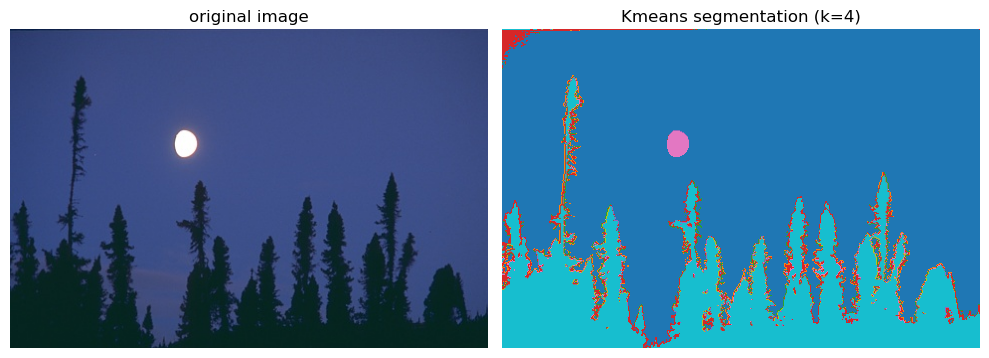

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def initialize_centroids(X, k):
    """ 随机选择K个初始中心点 """
    np.random.seed(0)  # 固定随机种子以确保可重复性
    indices = np.random.choice(len(X), k, replace=False)
    return X[indices]

def assign_labels(X, centroids):
    """ 为每个点分配标签，标签为最近的中心点的索引 """
    labels = np.zeros(len(X), dtype=int)
    for i in range(len(X)):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        labels[i] = np.argmin(distances)
    return labels

def update_centroids(X, labels, k):
    """ 更新中心点位置为对应簇的均值 """
    new_centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        new_centroids[i] = X[labels == i].mean(axis=0)
    return new_centroids

def kmeans(X, k, max_iters=100):
    """ K均值主算法 """
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        labels = assign_labels(X, centroids)
        new_centroids = update_centroids(X, labels, k)

        # 检查收敛
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return labels, centroids

def segment_image(image, k):
    """ 使用K均值对图像进行分割 """
    # 将图像从二维数组转换为一维数组
    Z = image.reshape((-1, 3))  # 将图像展平
    Z = Z.astype(np.float32)

    # 执行K均值算法
    labels, _ = kmeans(Z, k)

    # 将标签转换为分割后的图像
    segmented_image = labels.reshape(image.shape[:2])
    return segmented_image

# 读取图像
image = cv2.imread('test3_2.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 进行分割
k = 4  # 选择分割成3个区域
segmented_image = segment_image(image_rgb, k)

# 绘制结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("original image")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Kmeans segmentation (k={k})")
plt.imshow(segmented_image, cmap='tab10')  # 使用colormap来显示分割结果
plt.axis('off')

plt.tight_layout()
plt.show()

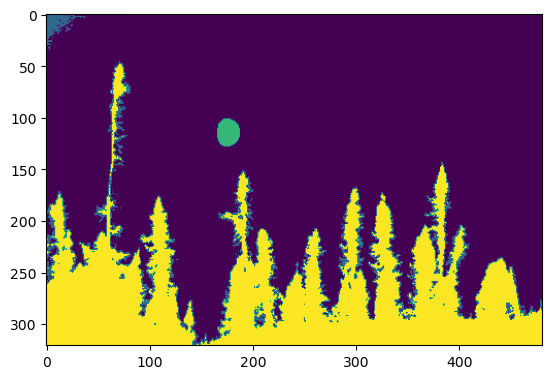

In [12]:
plt.imshow(segmented_image)